<a href="https://colab.research.google.com/github/alexandrefigcam/algoritmo_busca_inteligente/blob/main/BuscaInteligente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Busca Inteligente

* Implementação de algoritmos de busca inteligente em profundidade e em largura para atuarem em um labirinto. O objetivo é fazer com que tais algoritmos obtenham êxito na descoberta do caminho correto que leva a um objetivo final.

* O código abaixo apresenta uma classe para a criação do labirinto, outra para os agentes que realizam busca em largura e profundidade, e uma classe para o A*(algoritmo de busca baseado em heurística).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

In [3]:
class Labirinto:

    def __init__(self, dim = 50):
      self.labPlot = np.zeros((dim, dim, 3), dtype = np.int64)
      self.labPassagem = np.zeros((dim,dim), dtype = np.int64)
      self.dim = dim

      front = [] #Vetor que recebe todas as células válidas
      pos_inicial = np.random.randint(0, (dim -1))
      front.append((pos_inicial, 0))

      dx = [0, 1, 0, -1]
      dy = [1, 0, -1, 0]

      while front != []:
        (vx,vy) = front[-1]
        self.labPassagem[vx,vy] = 1
         
        aux = []
        # A cada iteração, caminha-se para um célula vizinha
        for i in range(4):
          nx = vx + dx[i]
          ny = vy + dy[i]

          if nx >= 0 and nx < self.dim and ny >= 0 and ny < self.dim:
            if self.labPassagem[nx,ny] == 0:
               
              #A cada iteração, caminha-se para uma célula vizinha da vizinha
              celulaValida = 0
              for j in range(4):
                ex = nx + dx[j]
                ey = ny + dy[j]
                
                #Verifica se a célula possui somente um vizinho configurado como célula válida
                if ex >= 0 and ex < self.dim and ey >= 0 and ey < self.dim:
                  if self.labPassagem[ex, ey] == 1:
                    celulaValida += 1

              if celulaValida == 1:
                  aux.append(i)
              
        if len(aux) > 0:
          irPara = np.random.choice(aux)
          vx += dx[irPara]
          vy += dy[irPara]
          front.append((vx,vy))
        else:
          front.pop()

      encontrou= False
      while not encontrou:
        pos_final = np.random.randint(0,(dim-1))
        if self.labPassagem[pos_final, dim-1] ==1:
            encontrou=True
      
      
      #Insere o mapa das passagens nas matizes do desenho e as pinta de branco
      self.labPlot[:,:, 0] += 255*self.labPassagem
      self.labPlot[:, :, 1] += 255*self.labPassagem
      self.labPlot[:,:, 2] += 255*self.labPassagem

      self.labPlot[pos_inicial, 0, 1] = 0
      self.labPlot[pos_inicial, 0, 2] = 0

      self.labPlot[pos_final, dim -1, 0] = 0
      self.labPlot[pos_final, dim - 1, 1] = 0

      self.posInicial = (pos_inicial, 0)
      self.posFinal = (pos_final, dim - 1)

    #Imprime o status da busca em profunidade ou largaura
    def getPlot(self, posicoes = None, cores = (255, 0, 0)):
        if posicoes == None:
          return self.labPlot
        
        auxiliar = self.labPlot.copy()
        for (x,y) in posicoes:
          for camada in range(3):
            auxiliar[x,y, camada] = cores[camada]

        return auxiliar
    
    #Imprime o status da busca em caso de A*, que envolve o uso de nós
    def getPlotNode(self, posicoes = None, cores = (255, 0, 0)):
        if posicoes == None:
          return self.labPlot
        
        auxiliar = self.labPlot.copy()
        for node in posicoes:
          for camada in range(3):
            auxiliar[node.getX(),node.getY(), camada] = cores[camada]

        return auxiliar

    #Busca células vizinhas, da célula atual, que sejam válidas para serem exploradas
    def getVizinhos(self, cell):
      dx = [0, 1, 0, -1]
      dy = [1, 0, -1, 0]

      vx = cell[0]
      vy = cell[1]

      vizinhosNaoVisitados = []
      for j in range(4):
        nx = vx + dx[j]
        ny = vy + dy[j]

        if nx >=0 and nx < self.dim and ny >= 0 and ny < self.dim:
          if self.labPassagem[nx,ny] == 1:
            vizinhosNaoVisitados.append((nx,ny))
      
      return vizinhosNaoVisitados

    def getPosInicial(self):
      return self.posInicial

    def getPosFinal(self):
      return self.posFinal

    def getGoal(self):
      return self.posFinal

      
      


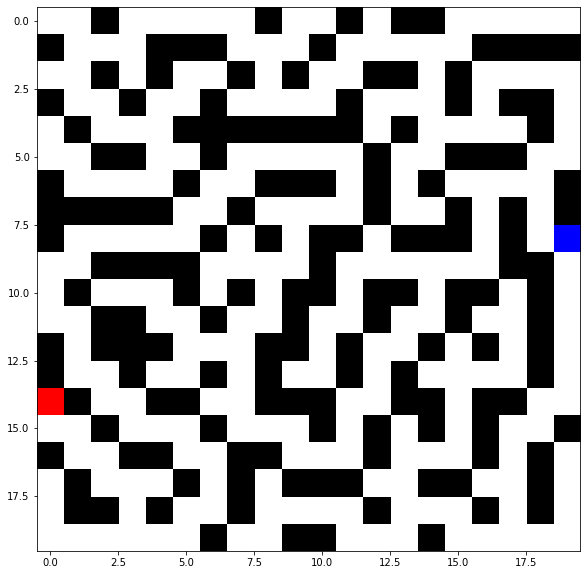

In [5]:
fig = plt.figure( figsize = (10,10))
labirinto = Labirinto(20)

plt.imshow(labirinto.getPlot())

# Agente inteligente 1( largura e profundidade)

A classe "Agent" possui como objetos agentes capazes  de efetuar busca em profundidade e busca em lagura.
   

*   Possui como métodos as buscas em largura e profundidade.
*   Possui, também, métodos auxiliares necessário paara a realização das buscas.




In [6]:
class Agent:
     
    def __init__(self, labirinto):
       self.labirinto = labirinto
       self.caminhos = []
       self.statusLabirinto = []
       self.fronteira = []
       self.celulasVisitadas =[]
    
    #Função auxiliar usada para destacar o caminho percorrido até o objetivo (quando ele é atingido).
    def selecionaCaminho(self, caminhos, celula):
      for v in caminhos:
        if v[-1] == celula:
          return v
    
    #Função auxiliar para a atuliazação dos caminhos de acordo com as novas células a serem exploradas
    def atualizaCaminho(self,caminhos, vizinho, celula):
       celulaNaoInserida = True
       for v in caminhos:
         if v[-1] == celula:
           celulaNaoInserida = False
           novo_v = v.copy()
           novo_v.append(vizinho)
           caminhos.append(novo_v)
       
       if celulaNaoInserida:
         v = []
         v.append(celula)
         v.append(vizinho)
         caminhos.append(v)
    
    #Busca em largura.
    def buscaEmLArgura(self):
      #Inicializa a fronteira com a célula inicial.
      self.fronteira.append(self.labirinto.getPosInicial())

      while self.fronteira != []:
         
        #Atualiza o status do labirinto de acordo com as células percorridas.
        self.statusLabirinto.append(self.labirinto.getPlot( posicoes = self.fronteira, cores = (0, 255, 127)))
        
        #Exploração da célula.
        celula = self.fronteira.pop(0)
        self.celulasVisitadas.append(celula)

        if celula == self.labirinto.getGoal():
          print(" Objetivo", celula, "encontrado")
          caminhoEncontrado = self.selecionaCaminho(self.caminhos, celula)
          self.statusLabirinto.append(self.labirinto.getPlot( posicoes = caminhoEncontrado, cores = (0,0, 255)))
          return self.statusLabirinto
        else:
          #Atualização da fronteira com os vizinhos válidos da última célula explorada
          for vizinhos in self.labirinto.getVizinhos(celula):
            if vizinhos not in self.celulasVisitadas:
              self.atualizaCaminho(self.caminhos, vizinhos, celula)
              self.fronteira.append(vizinhos)

      print("Objetivo não encontrado!")
    
    #Busca em profundidade
    def buscaEmProfundidade(self):
        self.fronteira.append(self.labirinto.getPosInicial())

        while self.fronteira != []:

           self.statusLabirinto.append(self.labirinto.getPlot( posicoes = self.fronteira, cores = (0, 255, 127)))

           celula = self.fronteira.pop()
           self.celulasVisitadas.append(celula)

           if celula == self.labirinto.getGoal():
             print(" Objetivo", celula, "encontrado")
             caminhoEncontrado = self.selecionaCaminho(self.caminhos, celula)
             self.statusLabirinto.append(self.labirinto.getPlot( posicoes = caminhoEncontrado, cores = (0,0, 255)))
             return self.statusLabirinto
           else:
             for vizinhos in self.labirinto.getVizinhos(celula):
               if vizinhos not in self.celulasVisitadas:
                 self.atualizaCaminho(self.caminhos, vizinhos, celula)
                 self.fronteira.append(vizinhos)

        print("Objetivo não encontrado!")




In [7]:
agente = Agent(labirinto)

snapshots = agente.buscaEmLArgura()

 Objetivo (8, 19) encontrado


#Agente inteligente 2 ( A*)


*   A classe "Aestrela" herda atributos e métodos da classe "Agent" necessários para a exploração do labirinto.  

*   Possui como objetos agentes que realizam a busca considerando o menor caminho.

*   A classe " Node " contém as células do labirinto a serem exploradas pelo algoritmo A*.







In [8]:
#Classe dos nós.
class Node:

    def __init__(self, x, y):
      self.x = x
      self.y = y
      self.custo = None
      self.f = None #soma do custo e a heurística

    # Calcula a função f = custo + heurística
    def calculaf(self, noInicial, noDestino):
     self.custo = np.abs( self.x - noInicial.getX()) - np.abs(self.y - noInicial.getY())
     self.f = self.custo + self.heuristica(noDestino)
     return self.f
    
    #Calcula a heurística.
    def heuristica(self, destino):
     return np.abs(self.x - destino.getX()) - np.abs(self.y - destino.getY())

    def getX(self):
     return self.x

    def getY(self):
     return self.y

    def coordenada(self):
      return (self.x, self.y)

In [9]:
#Classe do algoritmo A*
class Aestrela(Agent):

    def __init__(self, labirinto):
      Agent.__init__(self, labirinto)
      

    #Realiza a busca
    def busca(self):
       
      #Nó inicial
      (xo,yo) = labirinto.getPosInicial()
      noInicial = Node(xo,yo)
      
      #Nó de destino
      (xf, yf) = labirinto.getPosFinal()
      noFinal = Node(xf, yf)
      
      #Inicialização da fronteira com o nó inicial.
      self.fronteira.append(noInicial)
      

      while self.fronteira != []:
         #Atualiza o status do labirinto de acordo com os nós percorridos
         self.statusLabirinto.append(self.labirinto.getPlotNode(posicoes = self.fronteira , cores = (0, 255, 127)))

         celula = self.fronteira.pop(0)
         self.celulasVisitadas.append(celula.coordenada())

         if celula.coordenada() == self.labirinto.getGoal():
           print("Objetivo" , celula.coordenada(), "encontrado")
           caminhoEncontrado = self.selecionaCaminho(self.caminhos, celula.coordenada())
           self.statusLabirinto.append(self.labirinto.getPlot(posicoes = caminhoEncontrado, cores = (0, 0, 255)))
           return self.statusLabirinto
         else:
           for vizinhos in self.labirinto.getVizinhos(celula.coordenada()):
             if vizinhos not in self.celulasVisitadas:
               self.atualizaCaminho(self.caminhos, vizinhos, celula.coordenada())
               #Cada vizinho a ser explorado torna-se um objeto da classe "Node".
               (x,y) = vizinhos
               novoNode = Node(x,y)
               #Atualiza a fronteira e a modifica de modo que a prioridade seja dada aos nós de menor custo e heurística.
               self.fronteira.append(novoNode)
               self.fronteira.insert(0, self.getMin(self.fronteira, noInicial, noFinal))
               
      
      print("\n Objetivo não encontrado!!")

    #Método auxiliar que dá prioridade às células de menor valor de f = custo + heurística
    def getMin(self, fronteira, noInicial, noFinal):
      referencia = fronteira[0]
      indice = 0
      for j in range(len(fronteira)):
        if fronteira[j].calculaf(noInicial, noFinal) < referencia.calculaf(noInicial, noFinal):
          referencia = fronteira[j]
          indice = j

      fronteira.pop(indice)
      return referencia

In [10]:
aestrela = Aestrela(labirinto)
snapshots = aestrela.busca()

Objetivo (8, 19) encontrado


#Animando o Labirinto.


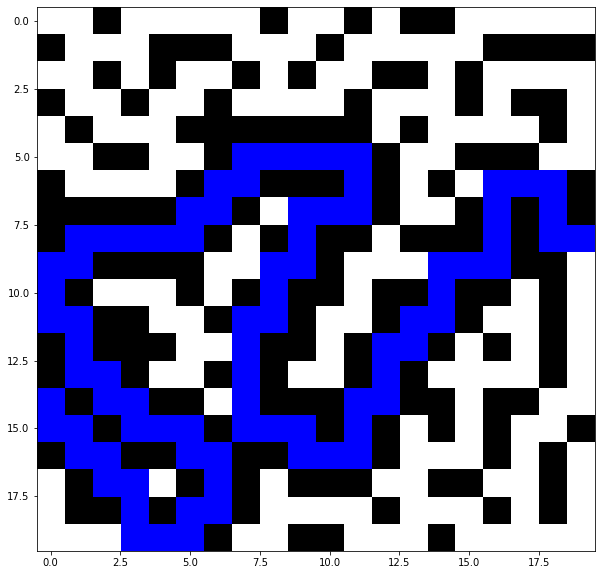

In [11]:
fig = plt.figure(figsize=(10,10))

# initialization function: plot the background of each frame
def init():
  a = labirinto.getPlot()
  im = plt.imshow(a, interpolation='none', aspect='auto', vmin=0, vmax=1)
  return [im]


def animate_func(i):
  im = plt.imshow(snapshots[i], interpolation='none', aspect='auto', vmin=0, vmax=1)
  #im.set_array(snapshots[i])
  return [im]

anim = animation.FuncAnimation(fig,
                               animate_func,
                               init_func=init,
                               frames=len(snapshots), # Numero de frames para animacao
                               interval=100, # Intervalo entre cada frame (em milisegundos)
                               blit=True)
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim
